# Noise2Void

## Overview 

Noise2Void (N2V) is a self-supervised denoising method. It trains by randomly masking
pixels in the input image and predicting their masked value from the surrounding pixels.

N2V relies on two fundamental hypotheses:

- The underlying structures are continuous
- The noise is pixel-wise independent

The corollory from these hypotheses is that if we consider the value of a pixel being
the sum of the true signal value and a certain amount of noise $x = s + \epsilon$, then:

- The true signal $s$ value can be estimated from the surrounding pixels
- The noise $\epsilon$ cannot be estimated from the surrounding pixels

Therefore, in cases where the hypotheses hold, if a pixel is masked, its noise cannot be
estimated from the surrounding pixels, while the true signal can. This is exactly how
N2V is trained!



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from careamics.transforms import N2VManipulate
from careamics_portfolio import PortfolioManager
from scipy.ndimage import convolve


def autocorrelation(x):
    """
    nD autocorrelation
    remove mean per-patch (not global GT)
    normalize stddev to 1
    value at zero shift normalized to 1...
    """
    x = (x - np.mean(x)) / np.std(x)
    x = np.fft.fftn(x)
    x = np.abs(x) ** 2
    x = np.fft.ifftn(x).real
    x = x / x.flat[0]
    x = np.fft.fftshift(x)
    return x


def get_hcorrelated_noise(shape, noise):
    purenoise = []
    noise_kernel = np.array([[1, 1, 1]]) / 3  ## horizontal correlations

    noise = convolve(noise, noise_kernel)

    purenoise = np.array(noise)
    purenoise = purenoise - purenoise.mean()

    return purenoise


# download file
portfolio = PortfolioManager()
files = portfolio.denoiseg.MouseNuclei_n0.download()
files.sort()

# load data
test_data = np.load(files[0])

(67, 256, 256)

## Training Noise2Void

Noise2Void is self-supervised, meaning that it trains with only the data itself. It relies 
on a classical [UNet architecture](#references). It applies a special augmentation 
called `N2V manipulate` that replaces random pixel values by the value of one of their 
neighbours (see the left column in the next figure).

During training, the output of the network is compared to an image that is only 
comprised of the original pixels that were offuscated during the augmentation. The loss
is only computed on these pixels, which means that the network is trained specifically
to predict the masked pixels values!

Below you can see two examples of the input to the network (left) and the masked pixels
used to compute the loss (right). The first example is a toy image that allows visualizing
the pixel replacement (it masks $2\%$ of the pixels). The second example is a realistic
image with the default N2V pixel manipulation parameters (e.g. $0.2\%$ of masked pixels).

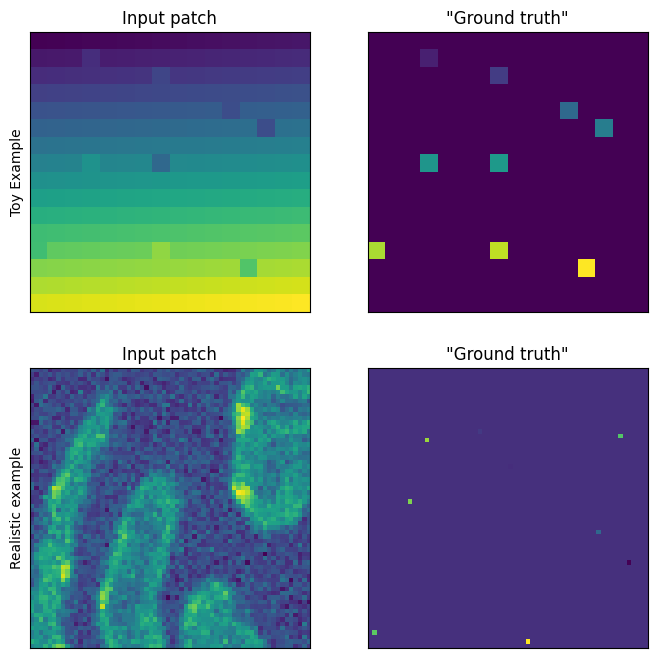

In [24]:
######### toy example
# array
scale = 16
patch = np.arange(scale**2).reshape((1, scale, scale))

# manipulate n2v
n2v_manipulate = N2VManipulate(roi_size=4, masked_pixel_percentage=2, seed=24)

# apply n2v manipulation
manipulated, _, mask = n2v_manipulate(patch)

######### real example
n2v_manipulate_real = N2VManipulate(seed=42)
scale = 32
real_patch = test_data["X_test"][3][:64, :64][np.newaxis, ...]
real_noisy = np.random.normal(0, 25, real_patch.shape)
real_noisy = real_patch + real_noisy
real_manipulated, _, real_mask = n2v_manipulate_real(real_noisy)

# show manipulated patch next to mask
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(manipulated.squeeze())
ax[0, 0].set_title("Input patch")
ax[0, 0].set_ylabel("Toy Example")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(mask.squeeze() * patch.squeeze())
ax[0, 1].set_title('"Ground truth"')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(real_noisy.squeeze())
ax[1, 0].set_title("Input patch")
ax[1, 0].set_ylabel("Realistic example")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(real_mask.squeeze() * real_noisy.squeeze())
ax[1, 1].set_title('"Ground truth"')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

plt.show()

## Interpreting the loss

As described above, the loss is computed by calculating the mean squared error over the
masked pixels:

$$loss = \dfrac{1}{N_{masked}}\sum_{i, masked}(x'_{i}-x_{i})^{2}$$

where $N_{masked}$ is the total number of masked pixels, $x'_{i}$ is the network prediction
for the masked pixel $i$, and $x_{i}$ is the original noisy value of pixel $i$.

As opposed to supervised approaches, where the loss is computed with respect to a known
ground truth, N2V computes the loss based on a noisy signal. At the beginning
of the training the network usually learns within a few epoch the rough structures in the
image and the loss decreases sharply. Then, it rapidly reaches a plateau and oscillates
around a particular loss value.

Because the loss is computed between prediction and noisy signal, its absolute value does
not inform on whether it is properly trained. Likewise, oscillation on the plateau does
not indicate that it does not learn anymore. 

The best way to assess the quality of the training is to look at the denoised images, 
potentially at different training points using the checkpoints. In practice, we often
simply train long enough for the image to look denoised!

If the training loss is not too informative, what about the validation loss? It is 
basically the same. If your validation loss increases, however, that does mean you are
overfitting and might need to add more images to the training set.


## Predicting on the training set

We are usually told that training and validation images should not be used to assess
the performance (even qualitatively) of the networl, because it was trained specifically
to perform well on them.

In Noise2Void, however, the network is trained without biasing it towards a ground-truth as
it is trained on noisy pixels. Therefore, it is perfectly fine to predict on the training
images.


## Re-using a trained model

Noise2Void learns both the noise distribution in the image and a structural prior, that 
is to say how the structures in the image look. As most deep learning networks, if you try
applying a trained neural network on images that are different from the training set, the
network will most likely fail and produce poor results.

This will happen with N2V if the noise distribution is different in the new images, or if
they contain different structures. Fortunately, N2V is quick to train, so you can train
a single network for each nea experiment!


## Why do N2V predictions look blurred?

For each noisy image, we often say that there is a whole distribution of possible denoised
images. In particular, for strongly degraded images, even different structures can produce
the same noisy patch. 

Because of this, a network trained with the mean squared error, such as N2V, will tend
to predict the average of all possible denoised images. This is why the prediction often
looks blurred. For approaches that predict single instances from the distribution of
possible denoised images, check out [DivNoising]() or [HDN]().


## Assessing quality

Denoising is a difficult task to assess quantitatively. The most common, and more accurate,
way to estimate the performances of a network is to compare its output with a ground truth
image. That means that you need to acquire images with and without noise. This can be done
by acquiring with more laser power, longer exposure time, or by averaging multiple images.
This is, however, often not possible. 

There are other ways perform controls on the quality of the denoising:

### Inspect the residuals

The residuals are the pixel intensity removed from the original image by the network:

$$res = image - pred$$

They correspond to the subtraction of the prediction from the original image. If the
residual show structures, then the training went wrong or the network did not train for 
long enough.

<p align="center">
  <img src="sem_n2v_residuals_comparison.png" width="700"/>
</p>


Note that in the presence of Poisson noise (such a shot noise in microscopy), the amount
of noise scales with the signal. Therefore, in such cases you will see "structures" because
areas of high intensity will have stronger fluctuations, as compared to low intensity 
part of the image. Structures in the residual should not be confused with the noise 
fluctuations scaling with the intensity.


### Training multiple networks

The training is stochastic, in order to assess whether structures are really in your 
image, you can do different types of experiments:

- Split your images in several set and train independent networks on each of the set. 
Compare the results.
- Train multiple networks on your training set and compare the results.

## Limitations

### Pixel-wise independent noise

It might happen that the noise is not pixel-wise independent. This is sometimes the case
with sCMOS camera or point-scanning microscopy methods. In these cases, Noise2Void might
introduce small artefacts or simply reinforce the correlated pattern in the denoised
image. 

To estimate whether the noise is correlated, once can perform image autocorrelation and 
check the shape of the central peak in the distribution. For instance, shown in the next 
figure are two examples of the same image with artificial Gaussian noise. In the second 
one, we introduced a correlation in the Gaussian noise, leading to an horizontal line in
the correlation.

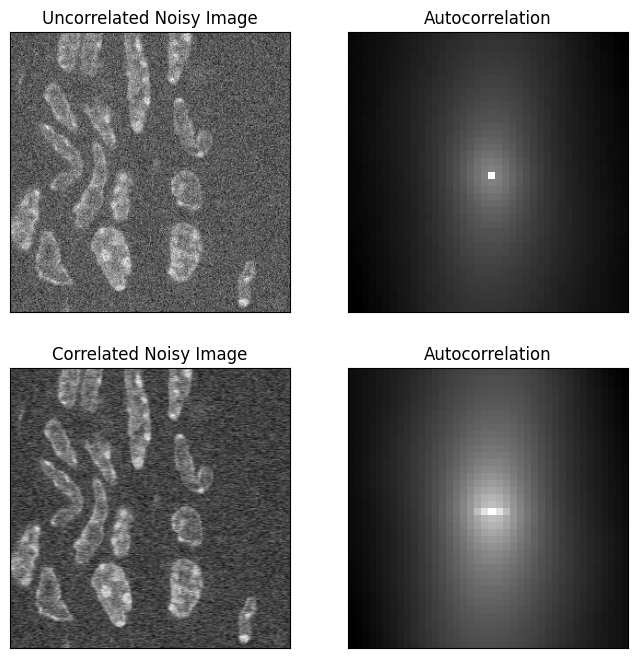

In [23]:
# compute noise and autocorrelation
clean_img = test_data["X_test"][0]
clean_img_autocorr = autocorrelation(clean_img)

# create a noisy image by adding 0 mean gaussian noise
sigma = 50
noisy = np.random.normal(0, sigma, clean_img.shape)
noisy_img = clean_img + noisy
noisy_img_autocorr = autocorrelation(noisy_img)

# add correlated noise
correlated_noise = get_hcorrelated_noise(clean_img.shape, noisy)
correlated_noisy_img = clean_img + correlated_noise
correlated_noisy_img_autocorr = autocorrelation(correlated_noisy_img)

# show images in one column and their correlation in the other
# crop the correlation around (0, 0)
midpoint = clean_img.shape[0] // 2
crop_size = 20
slices = (
    slice(midpoint - crop_size, midpoint + crop_size),
    slice(midpoint - crop_size, midpoint + crop_size),
)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(noisy_img, cmap="gray")
ax[0, 0].set_title("Uncorrelated Noisy Image")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(noisy_img_autocorr[slices], cmap="gray")
ax[0, 1].set_title("Autocorrelation")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(correlated_noisy_img, cmap="gray")
ax[1, 0].set_title("Correlated Noisy Image")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(correlated_noisy_img_autocorr[slices], cmap="gray")
ax[1, 1].set_title("Autocorrelation")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
plt.show()

# save image

### Checkboard artefacts

Checkboard artefacts occur in the presence of salt and pepper noise, or commonly 
observed hot pixels in sCMOS cameras. The presence of hot pixels can lead to the 
network predicting cross patterns. To avoid these artefacts, you can use [N2V2]().


### Correlated noise

(soon)

## References

Alexander Krull, Tim-Oliver Buchholz, and Florian Jug. "Noise2Void - learning denoising
from single noisy images." CVPR, 2019. [link](https://openaccess.thecvf.com/content_CVPR_2019/html/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.html)

Joshua Batson, and Loic Royer. "Noise2Self: Blind denoising by self-supervision." 
MLR, 2019. [link](http://proceedings.mlr.press/v97/batson19a.html)

Olaf Ronneberger, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for 
biomedical image segmentation." MICCAI, 2015. [link](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)